# 12. 트랜스포머로 만드는 대화형 챗봇



## 12-3. 트랜스포머의 입력 이해하기

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow_datasets as tfds

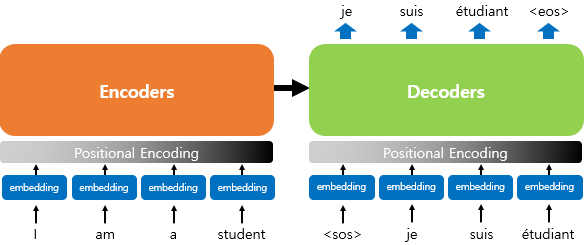

자연어 처리 모델들은 텍스트 문장을 입력으로 받기 위해 단어를 임베딩 벡터로 변환하는 벡터화 과정을 거친다. 하지만 트랜스포머 모델은 RNN계열의 모델들과 다르게 임베딩 벡터에 어떤 값을 더해준 뒤에 입력으로 사용한다 -> positional Encoding

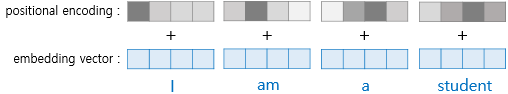

이렇게 하는 이유: 트랜스포머는 입력을 받을때 하나씩 순차적으로 받는게 아니라, 문장에 있는 모든 단어를 한꺼번에 입력으로 받기 때문이다. (RNN이랑 결정적으로 다른 부분)

RNN의 경우 어차피 문장을 구성하는 단어들이 어순대로 모델에 입력되므로, 모델에게 따로 어순 정보를 알려줄 필요가 없다. 근데 트랜스포머는 한꺼번에 문장 단위로 입력받으니까 i ate lunch/i lunch ate을 구분 못할지도 모름 그래서 몇번째 어순으로 입력되었는지를 모델에 알려주기 위해 위치 정보를 가진 벡터(positional encoding)값을 더해서 전달

임베딩 행렬 + 포지셔널 행렬을 더해서 각 단어 벡터에 위치 정보를 더해준다

같은 단어라도 포지셔널 인코딩을 해주면 임베딩 벡터값이 달라지므로 가각 다른 위치에 등장했다는 것을 알려준다

In [2]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

50 x 512 행렬을 그려보자(최대 문장의 길이가 50, 워드 임베딩 차원을 512로 하는 모델의 입력 벡터 모양)

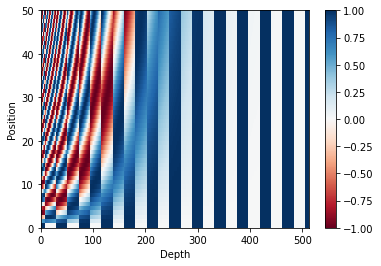

In [3]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0,512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## 12-4. 어텐션? 어텐션!

### 어텐션이란?
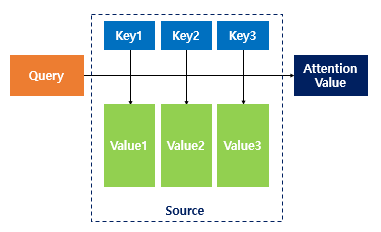

주어진 '쿼리'에 대해서 모든 키와의 유사도를 각각 구한다. 이 유사도를 키와 맵핑되어 있는 밸류에 반영해준다. 유사도가 반영된 값을 모두 더해서 뭉쳐주면 최종 결과인 attention value가 나온다


### 트랜스포머에서 사용된 어텐션
총 세가지의 어텐션을 사용함

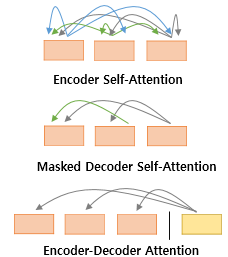

1. 인코더 셀프 어텐션 (인코더) : 인코더의 입력으로 들어간 문장 내 단어들이 서로 유사도를 구한다
2. 디코더 셀프 어텐션 (디코더) : 단어를 1개씩 생성하는 디코더가 이미 생성된 앞 단어들과의 유사도를 구한다
3. 인코더-디코더 어텐션 (디코더에서 이루어짐) : 디코더가 잘 예측하기 위해서 인코더에 입력된 단어들과 유사도를 구한다

결국 유사도를 구하는게 어텐션!!!

- 쿼리, 키, 밸류? -> 기본적으로 단어(정보를 함축한) 벡터
- 여기서 단어 벡터 는 초기 임베딩 벡터가 아니라 트랜스포머 연산을 거친 후의 단어 벡터!!

### 셀프 어텐션(self attention)
: 유사도를 구하는 대상이 다른 문장의 단어가 아니라 현재 문장 내의 단어들이 서로 유사도를 구하는 경우

인코더-디코더 어텐션의 경우 인코더 내의 단어와 디코더 내의 단어 사이에서 유사도를 구하니까 셀프 어텐션이 아님

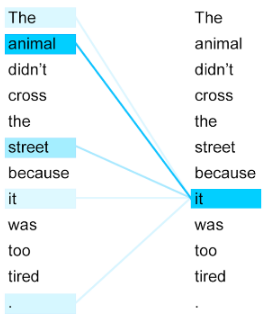
https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html

위 그림에서 it은 street인가 animal인지 기계가 정확하게 알 수가 없으니까, 셀프어텐션으로 입력 내 문장 내 단어들끼리 유사도를 구해서 it = animal이랑 연관된다라는 것을 찾아낸다.

## 12-5. 스케일드 닷 프로덕트 어텐션

내적(dot product)을 통해 단어 벡터 간 유사도를 구한 후에, 특정 값을 분모로 나눠주는 방식으로 Q와 K의 유사도를 구한다.

### 구현하기
스케일드 닷 프로덕트 어텐션 함수

In [5]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

## 12-6. 머리가 여러 개인 어텐션

### 병렬로 어텐션 수행하기
트랜스포머에서 num_heads라는 변수는 기계가 몇개의 머리를 사용할지, 병렬적으로 몇개의 어텐션 연산을 수행할지를 결정하는 하이퍼 파라미터

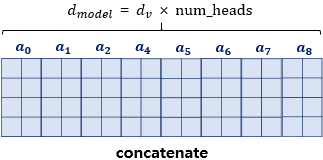

포지셔널 인코딩에서 d_model은 임베딩 벡터의 차원이다. 결국 트랜스포머의 초기 입력인 문장 행렬의 크기는 문장의 길이를 행으로 하고 d_model을 열의 크기로 가짐

입력된 문장 행렬을 num_heads의 수만큼 나눠서 어텐션을 수행하고 이렇게 얻은 num_headd의 개수만큼 어텐션 값 행렬을 다시 하나로 concateneate한다

위 그림에서처럼 num head수가 결국 d_model이 된다(열 크기)

### 멀티-헤드 어텐션

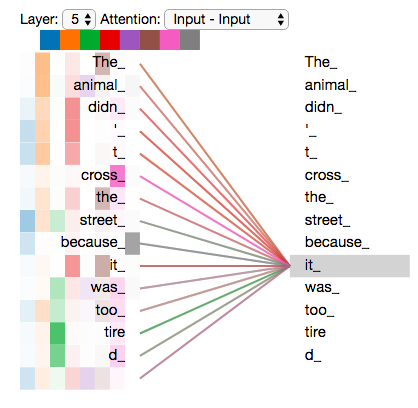
[출처 : http://jalammar.github.io/illustrated-transformer/]

그림처럼 head 값이 8일 때, 병렬로 수행되는 어텐션이 서로 다른 셀프 어텐션 결과를 얻을 수 있음을 보여준다. 각각 다른 관점에서 어텐션을 수행하니까 한번만할때보다 정보를 덜 놓친다. 이렇게 병렬로 어텐션 수행하는게 멀티헤드 어텐션 !

In [6]:
# 멀티헤드 어텐션 구현하기 -> 내부적으로는 스케일 닷 프로덕트 어텐션 함수 호출
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

## 12-7. 마스킹
: 특정 값들을 가려서 실제 연산에 방해가 되지 않도록 하는 기법, 크게 두가지가 있다

### 패딩 마스킹

자연어 처리에서 패딩이란? 문장의 길이가 다를때, 문장읙 길이를 동일하게 해주는 과정에서 짧으면 숫자 0을 채워서 문장의 길이를 맞춰주는 자연어 처리 전처리 방법
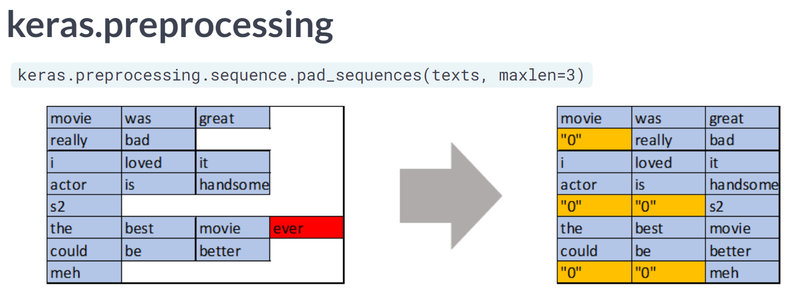

숫자 0은 의미가 없으므로 어텐션같은 연산에서는 제외한다. 패딩 마스킹은 이를 위해서 숫자 0인 부분을 체크함

In [7]:
# 패딩 마스킹 구현
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

이 함수에 정수 시퀀스를 입력으로 하면 이 함수는 숫자가 0인 부분을 체크한 벡터를 리턴

In [8]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


숫자가 0인 부분만 1로 나온다 아닌 부분은 0으로

### 룩 어헤드 마스킹(Look-ahead masking, 다음 단어 가리기)

RNN과 트랜스포머의 문장을 입력받는 방법을 비교해보자

#### RNN : step마다 단어가 순서대로 입력된다
구조상으로 다음 단어를 만들어 갈 때, 앞에 있는 단어들만 참고해서 다음 단어를 예측한다
1. 첫 번째 step : what -> 12
2. 두 번째 step : what is -> the
3. 세 번째 step : what is the -> problem

#### 트랜스포머 : 한꺼번에 전체 문장이 입력된다
위치와 상관없이 모든 단어를 참고해서 다음 단어를 예측할 수 있다
아무튼 자신보다 다음에 나올 단어를 참고하지 않도록 가리는 방법이 룩 어헤드 마스킹 !

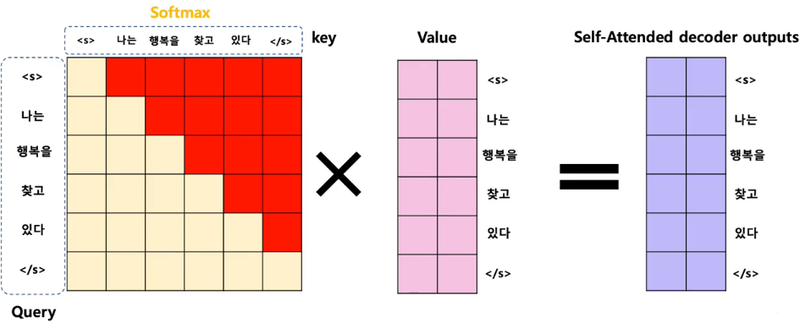
https://www.youtube.com/watch?v=xhY7m8QVKjo

빨간색 부분이 마스킹 -> 실제 어텐션 연산에서 가리는 역할을 한다 이전 단어들하고만 유사도를 구한다
행을 query, 열을 key로 표현한 행렬임

예를 들어 쿼리 단어가 '찾고'면 이 찾고의 행에는 s, 나는, 행복을, 찾고 까지만 열이 보이고 그 뒤는 빨간색으로 칠해져 있다. 즉 유사도를 못찾게 해놓음

In [11]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [12]:
print(create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


이 마스킹이랑 패딩 마스킹은 별개라서, 만약에 숫자 0인 단어가 있으면 이것도 패딩해야함
그래서 함수 안에 패딩 마스크 함수 호출도 들어있다

In [14]:
# 숫자 0이 포함되었을 경우도 테스트
print(create_look_ahead_mask(tf.constant([[0, 5, 1, 5, 5]])))

tf.Tensor(
[[[[1. 1. 1. 1. 1.]
   [1. 0. 1. 1. 1.]
   [1. 0. 0. 1. 1.]
   [1. 0. 0. 0. 1.]
   [1. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


## 12-8. 인코더

이제 트랜스포머 인코더를 설계해보자!

#### 인코더 층 만들기

하나의 인코더 층은 크게 두개의 서브층으로 나뉜다 = 셀프 어텐션 + 피드 포워드 신경망

셀프어텐션은 멀티헤드 어텐션으로 병렬구조로 이루어짐

내부적으로 두개의 서브 층을 가지는 하나의 인코더 층을 구현하는 함수를 만들어보자

In [15]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

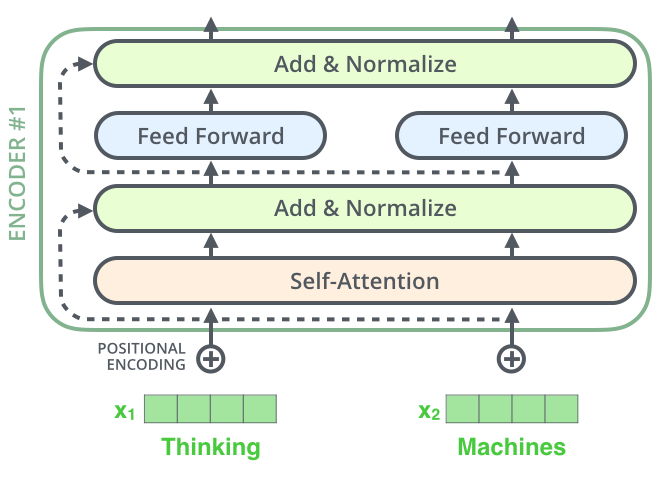
[출처 : http://jalammar.github.io/illustrated-transformer/]

### 인코더 층을 쌓아 인코더 만들기

구현한 인코더 층을 임베딩 층과 포지셔널 인코딩을 연결하고, 원하는 만큼 인코더 층을 쌓으면 트랜스포머 인코더가 완성된다

인코더와 디코더 내부에는 layer normalization이라는 테크닉이 들어감(nomalize)
num_layers 하이퍼 파라미터로 인코더 층을 쌓는다.

In [16]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

## 12-9. 디코더

디코더는 세개의 서브층으로 구성된다
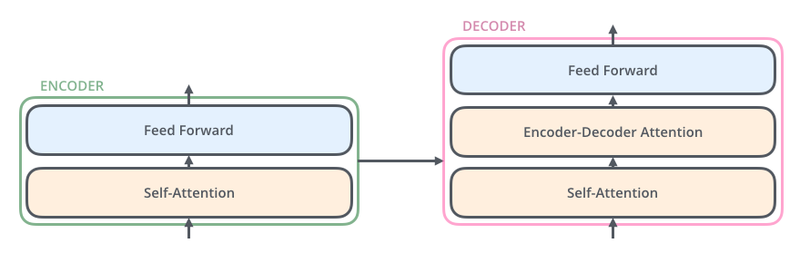
[출처 : http://jalammar.github.io/illustrated-transformer/]

셀프 어텐션 , 인코더-디코더 어텐션, 피드 포워드 신경망


In [17]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

### 디코더 층을 쌓아 디코더 만들기
구현한 디코더의 층은 임베딩 층과 포지셔널 인코딩을 연결하고, 사용자가 원하는 만큼 디코더 층을 쌓으면 트랜스포머의 디코더가 완성된다

마찬가지로 num_layers로 디코더 층을 쌓는다

In [19]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

## 12-10. 챗봇의 병렬 데이터 받아오기

Cornel Movie-Dialogs Corpus라는 영화 및 티비 프로그램에서 사용되었던 대화의 쌍으로 구성된 데이터셋을 사용한다(먼저 말하는 사람 문장-그에 응답하는 대화 문장)

이번 스텝의 목표 

1. 정해진 개수인 50000개의 질문과 답변의 쌍 추출
2. 문장에서 단어와 구두점 사이에 공백 추가
3. 알파벳과 !?,. 이 4개의 구두점을 제외한 다른 특수문자 제거

In [20]:
path_to_zip = tf.keras.utils.get_file(
    'cornell_movie_dialogs.zip',
    origin='http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip',
    extract=True)

path_to_dataset = os.path.join(
    os.path.dirname(path_to_zip), "cornell movie-dialogs corpus")

path_to_movie_lines = os.path.join(path_to_dataset, 'movie_lines.txt')
path_to_movie_conversations = os.path.join(path_to_dataset,'movie_conversations.txt')

9928704/9916637 [==============================] - 1s 0us/step


In [21]:
# 사용할 샘플의 최대 개수
MAX_SAMPLES = 50000
print(MAX_SAMPLES)

50000


이번 전처리는 정규 표현식을 사용해서 구두점을 제거해 단어를 토큰화하는 데 방해되지 않도록 정제하는 것을 목표로 한다

In [23]:
# 전처리 함수
def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이 거리 만들기
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만든다
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체
  sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
  sentence = sentence.strip()
  return sentence

데이터 로드 + 전처리 함수 호출 동시에 ㄱ ㄱ 질문과 답변의 쌍을 전처리한다

In [25]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
def load_conversations():
  id2line = {}
  with open(path_to_movie_lines, errors='ignore') as file:
    lines = file.readlines()
  for line in lines:
    parts = line.replace('\n', '').split(' +++$+++ ')
    id2line[parts[0]] = parts[4]

  inputs, outputs = [], []
  with open(path_to_movie_conversations, 'r') as file:
    lines = file.readlines()

  for line in lines:
    parts = line.replace('\n', '').split(' +++$+++ ')
    conversation = [line[1:-1] for line in parts[3][1:-1].split(', ')]

    for i in range(len(conversation) - 1):
      # 전처리 함수를 질문에 해당되는 inputs와 답변에 해당되는 outputs에 적용.
      inputs.append(preprocess_sentence(id2line[conversation[i]]))
      outputs.append(preprocess_sentence(id2line[conversation[i + 1]]))

      if len(inputs) >= MAX_SAMPLES:
        return inputs, outputs
  return inputs, outputs


In [26]:
# 데이터 샘플 수 확인
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장한다
questions, answers = load_conversations()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 50000
전체 샘플 수 : 50000


In [27]:
# 21번 샘플로 확인
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: she s not a . . .
전처리 후의 22번째 답변 샘플: lesbian ? no . i found a picture of jared leto in one of her drawers , so i m pretty sure she s not harboring same sex tendencies .


구두점 사이에 공백이 추가된 것을 확인, 이렇게 함으로써 단어를 토크나이징 하는 과정에서 붙어있던 단어들을 하나의 단어로 인식하는 것을 방지한다

## 12-11. 병렬 데이터 전처리하기

질문과 답을 각각 question과 answer에 저장했다. 본격적으로 전처리 ㄱ ㄱ 

1. TensorFlow Datasets SubwordTextEncoder를 토크나이저로 사용한다.  단어보다 더 작은 단위인 Subword를 기준으로 토크나이징하고,  각 토큰을 고유한 정수로 인코딩한다.
2. 각 문장을 토큰화하고 각 문장의 시작과 끝을 나타내는 START_TOKEN 및 END_TOKEN을 추가한다.
3. 최대 길이 MAX_LENGTH인 40을 넘는 문장들은 필터링한다.
4. MAX_LENGTH보다 길이가 짧은 문장들은 40에 맞도록 패딩 한다.

### 1. 단어장 (vacabulary)만들기

In [28]:
import tensorflow_datasets as tfds
print("살짝 오래 걸린당 ~~~")

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성. (Tensorflow 2.3.0 이상) (클라우드는 2.4)
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

살짝 오래 걸린당 ~~~


In [29]:
import tensorflow_datasets as tfds

In [30]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여한다. 생성된 단어장의 번호와 겹치지 않도록 각각 단어장의 크기보다 크게
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [31]:
# 시작 토큰과 종료 토큰에 부여된 정수를 출력
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8331]
END_TOKEN의 번호 : [8332]


In [32]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8333


### 2. 각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)

위에서 tensorflow_datasets의 SubwordTextEncoder를 사용해서 tokenizer를 정의하고 vocabulary를 만들었다면, tokenizer.encode() 로 단어 -> 정수로 변환 가능, .decode()로 정수 -> 단어 시퀀스로 변환 가능

In [33]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [60, 8, 37, 8172, 49]
정수 인코딩 후의 21번째 답변 샘플: [7824, 1223, 19, 61, 2, 4, 336, 10, 1595, 14, 1104, 698, 3263, 263, 16, 71, 14, 107, 2133, 900, 3, 59, 4, 23, 355, 204, 60, 8, 37, 885, 2289, 8107, 344, 1001, 5179, 4214, 342, 1]


In [34]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [35]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

샘플 길이가 40 넘는 경우는 제외되었음

In [36]:
# 단어장 크기와 샘플 개수 확인
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8333
필터링 후의 질문 샘플 개수: 44095
필터링 후의 답변 샘플 개수: 44095


### 3. 교사 강요(Teacher Forcing) 사용하기

tf.data.Dataset API는 훈련 프로세스의 속도가 빨라지도록 입력 파이프라인을 구축한다. 이것을 적극 사용하기 위해 질문과 답변의 쌍을 tf.data.Dataset의 입력으로 넣어주는 작업을 하는데. 디코더의 입력과 실제값을 정의해주기 위해서는 교사 강요라는 언어모델의 훈련 기법을 이해해야 한다.

교사 강요를 하지 않은경우 잘못된 예측이 다음 시점의 입력으로 들어가면서 연쇄적으로 예측 정확도에 영향을 주어 훈련속도가 느려질 수 있음

자신의 출력이 현재 자신의 상태를 결정하는 모델 = 자귀회귀 모델, RNN과 트랜스포머 디코더도 이에 속한다.

질문과 답변의 쌍을 tf.data.Dataset API의 입력으로 사용하여 파이프라인을 구성한다. 이때, 교사 강요를 위해서 answers[:, :-1]를 디코더의 입력값, answers[:, 1:]를 디코더의 레이블로 사용

In [38]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

## 12-12. 모델 정의 및 학습하기

앞서 사용한 인코더 함수 디코더 함수 써서 트랜스포머 함수 정의

In [41]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

### 1. 모델 생성
하이퍼파라미터 = num_layers, d-Model, units

In [42]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3187456     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

### 2. 손실 함수(Loss function)
레이블인 시퀀스에 패딩이 되어 있어서 loss계산 시 패딩 마스크 적용


In [43]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

### 3. 커스텀 된 학습률(Learning rate)
딥러닝 모델학습에서 learning rate는 매우 중요한 파라미터. 

최근에는 모델 학습 초기에 러닝레이트를 높였다가 train step이 진행됨에 따라 서서히 낮추어 가면서 안정적으로 수렴하게 하는 커스텀 학습률 스케줄링을 널리 사용한다

커스텀 학습률 스케줄러를 통한 아담 옵티마이즈 사용

In [46]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

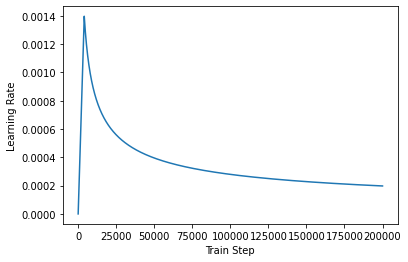

In [47]:
# 학습률 스케줄링 계획 시각화 -> 러닝레이트가 step_num에 비례해서 증가하다가 이후로 감소
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### 4. 모델 컴파일
손실함수와 커스텀된 학습률을 사용해서 컴파일

In [49]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

### 5. 훈련하기

In [50]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
689/689 [==============================] - 52s 56ms/step - loss: 2.1070 - accuracy: 0.0416
Epoch 2/20
689/689 [==============================] - 38s 55ms/step - loss: 1.5028 - accuracy: 0.0786
Epoch 3/20
689/689 [==============================] - 38s 55ms/step - loss: 1.3988 - accuracy: 0.0857
Epoch 4/20
689/689 [==============================] - 38s 55ms/step - loss: 1.3392 - accuracy: 0.0901
Epoch 5/20
689/689 [==============================] - 38s 55ms/step - loss: 1.2878 - accuracy: 0.0943
Epoch 6/20
689/689 [==============================] - 38s 55ms/step - loss: 1.2404 - accuracy: 0.0977
Epoch 7/20
689/689 [==============================] - 38s 55ms/step - loss: 1.1853 - accuracy: 0.1020
Epoch 8/20
689/689 [==============================] - 38s 55ms/step - loss: 1.1233 - accuracy: 0.1072
Epoch 9/20
689/689 [==============================] - 38s 55ms/step - loss: 1.0647 - accuracy: 0.1130
Epoch 10/20
689/689 [==============================] - 38s 55ms/step - loss: 1.011

## 12-13. 챗봇 테스트하기
예측 단계 : 

1. 새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.
2. 입력 문장을 토크나이징하고, START_TOKEN과 END_TOKEN을 추가한다.
3. 패딩 마스킹과 룩 어헤드 마스킹을 계산한다.
4. 디코더는 입력 시퀀스로부터 다음 단어를 예측한다.
5. 디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.
6. END_TOKEN이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.

싹 다 포함해서 decoder_inference()함수 생성

In [52]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가
    # 이 output_sequence는 다시 디코더의 입력이 된다
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

임의의 입력 문장에 대해 decoder_inference()함수를 호출해서 챗봇의 대답을 얻는 sentence_generation()함수를 만든다

In [53]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받는다
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

In [54]:
# 임의의 문장으로부터 대답을 얻어보자 !
sentence_generation('Where have you been?')

입력 : Where have you been?
출력 : i m a paleontologist .


'i m a paleontologist .'

In [55]:
sentence_generation("It's a trap")

입력 : It's a trap
출력 : i m sorry , but this isn t happening .


'i m sorry , but this isn t happening .'